In [1]:
# change to parent directory to import module
%cd ..

/home/achilleas/projects/osbuild/metrics


In [2]:
# imports, function definitions, and global settings
import json
import pandas
import report

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import ibmetrics as ib

from datetime import datetime, timedelta

from IPython.display import display, Markdown


def mdprint(msg):
    display(Markdown(msg))
    
matplotlib.rc('font', size=24)

In [3]:
# read data
now = datetime.now()
year = now.year
month = now.month
# load data from the first day of the current month
builds = ib.reader.read(f"./data/parquet/builds/year_created={year}/month_created={month}/day_created=1")
users = pandas.read_json("./data/userinfo.json", dtype=False)
with open("./data/userfilter.txt", encoding="utf-8") as filterfile:
    user_filter = filterfile.read().split("\n")
    
subscriptions = ib.reader.read_subscriptions("./data/subscriptions/")

filter_ids = ib.data.get_filter_ids(users, user_filter)

mdprint(f"Builds: Read {len(builds)} records")
mdprint(f"Subscriptions: Read {len(subscriptions)} records")

Builds: Read 15910 records

Subscriptions: Read 9581 records

In [4]:
# filtering: remove builds before GA
ga_date = datetime(2022, 5, 4)
ga_idxs = builds["created_at"] >= ga_date
builds = builds.loc[ga_idxs]

# filtering: remove builds of incomplete (current) month
month_start = datetime(year=year, month=month, day=1)
builds = builds.loc[builds["created_at"] < month_start]
mdprint(f"Builds: Using {len(builds)} records (since GA to start of month)")
subscriptions = subscriptions.loc[subscriptions["created"] < month_start]
mdprint(f"Subscriptions: Using {len(subscriptions)} records (since GA to start of month)")

# filtering: remove internal users
builds = ib.data.filter_orgs(builds, filter_ids)
mdprint(f"Builds: Using {len(builds)} records (after filtering)")
subscriptions = ib.data.filter_orgs(subscriptions, filter_ids)
mdprint(f"Subscriptions: Using {len(subscriptions)} records (after filtering)")

# Subscription records can appear in the data with start dates before the introduction of the RHSM fact (September 2022).
# We don't know what this means (yet). For now, clamp these to the fact introduction date, but don't drop them.
sub_start = datetime(2022, 9, 1)
subscriptions["created"] = subscriptions["created"].clip(lower=sub_start)

Builds: Using 14076 records (since GA to start of month)

Subscriptions: Using 9423 records (since GA to start of month)

Builds: Using 7419 records (after filtering)

Subscriptions: Using 3697 records (after filtering)

In [5]:
summary = ib.metrics.make_summary(builds)
mdprint(ib.metrics.summarise(summary))

Summary
=======

Period: 2022-05-04 14:11:47.137615 - 2023-03-31 22:18:34.798042

- Total builds: 7419
- Number of users: 3120
- Builds with packages: 3356
- Builds with filesystem customizations: 1754
- Builds with custom repos: 130

In [6]:
# Calculate total subscribed machine duration
durations = []

n_active = 0
# machine is active if it checked in after the cutoff: last day of the month we're looking at
cutoff = month_start - timedelta(days=1)
for _, sub in subscriptions.iterrows():
    start = np.datetime64(sub["created"])
    
    if pandas.isnull(sub["lastcheckin"]):
        # skip machines that never checked in after creation
        continue
    end = sub["lastcheckin"]

    d = (end-start).seconds
    
    if end > cutoff:
        n_active += 1
    durations.append(d)

total_duration = sum(durations)
print(f"{total_duration} seconds total active instances")
print(f"{np.mean(durations)} seconds average lifetime per instance")
print(f"{n_active} active instances (checked in within one day before {month_start})")
print(f"{len(durations)} instances that checked in at least once")

58089995 seconds total active instances
22852.083005507473 seconds average lifetime per instance
486 active instances (checked in within one day before 2023-04-01 00:00:00)
2542 instances that checked in at least once


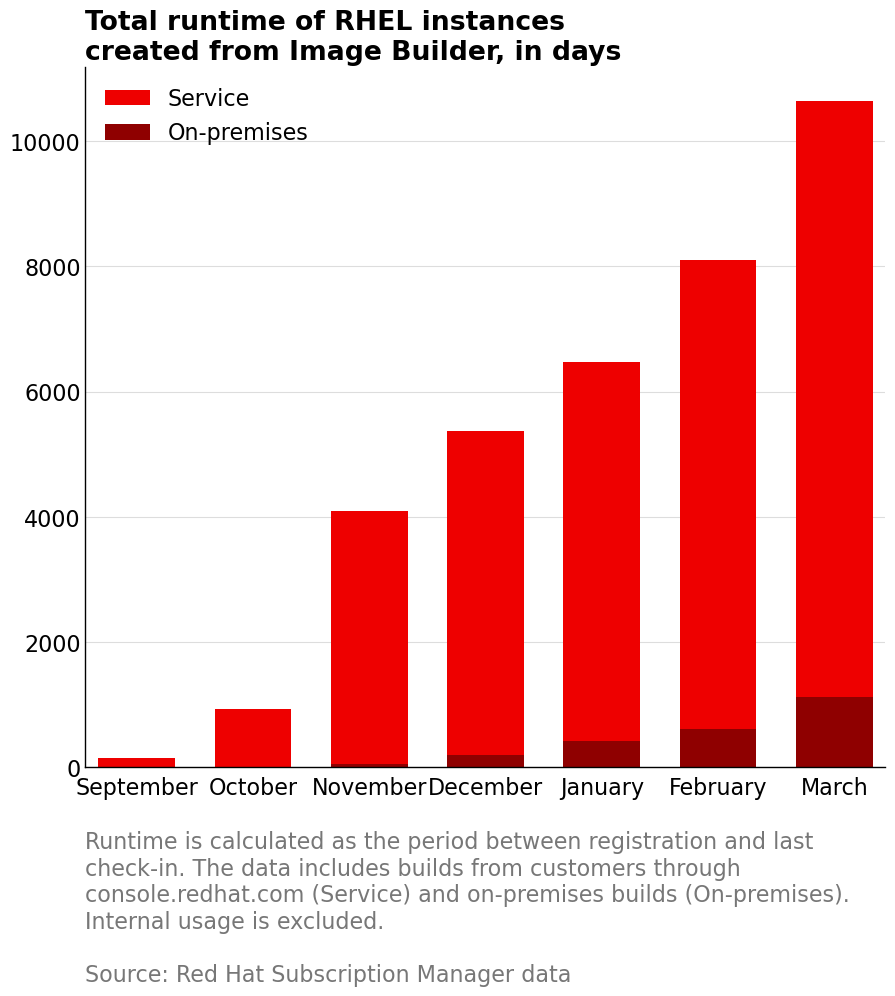

In [7]:
fig = plt.figure(figsize=(8, 7))
ib.plot.monthly_active_time(subscriptions, fig)

In [8]:
fig = plt.figure(figsize=(8, 7))
ib.plot.monthly_users_stacked(builds, fig)

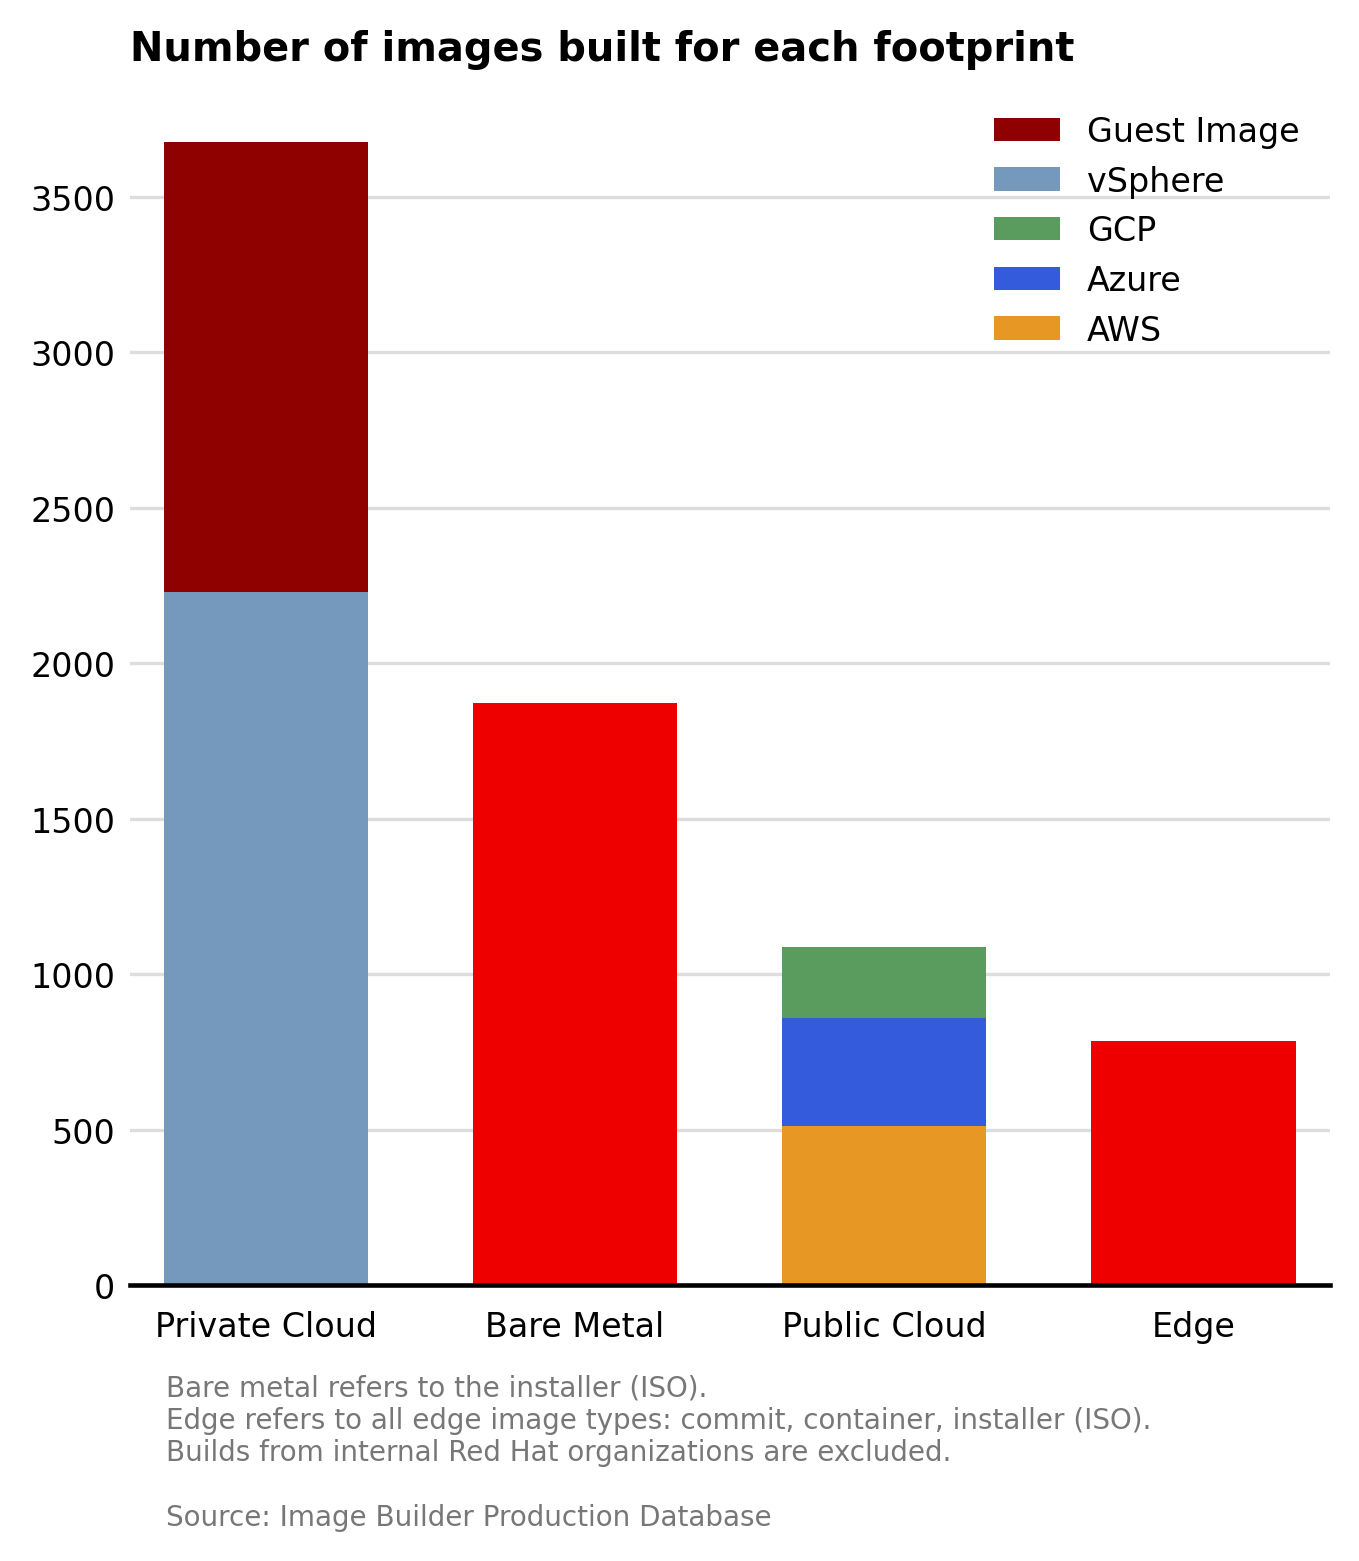

In [9]:
fig = plt.figure(figsize=(4, 4))
ib.plot.footprints_stacked(builds, fig)

2181 total builds in March


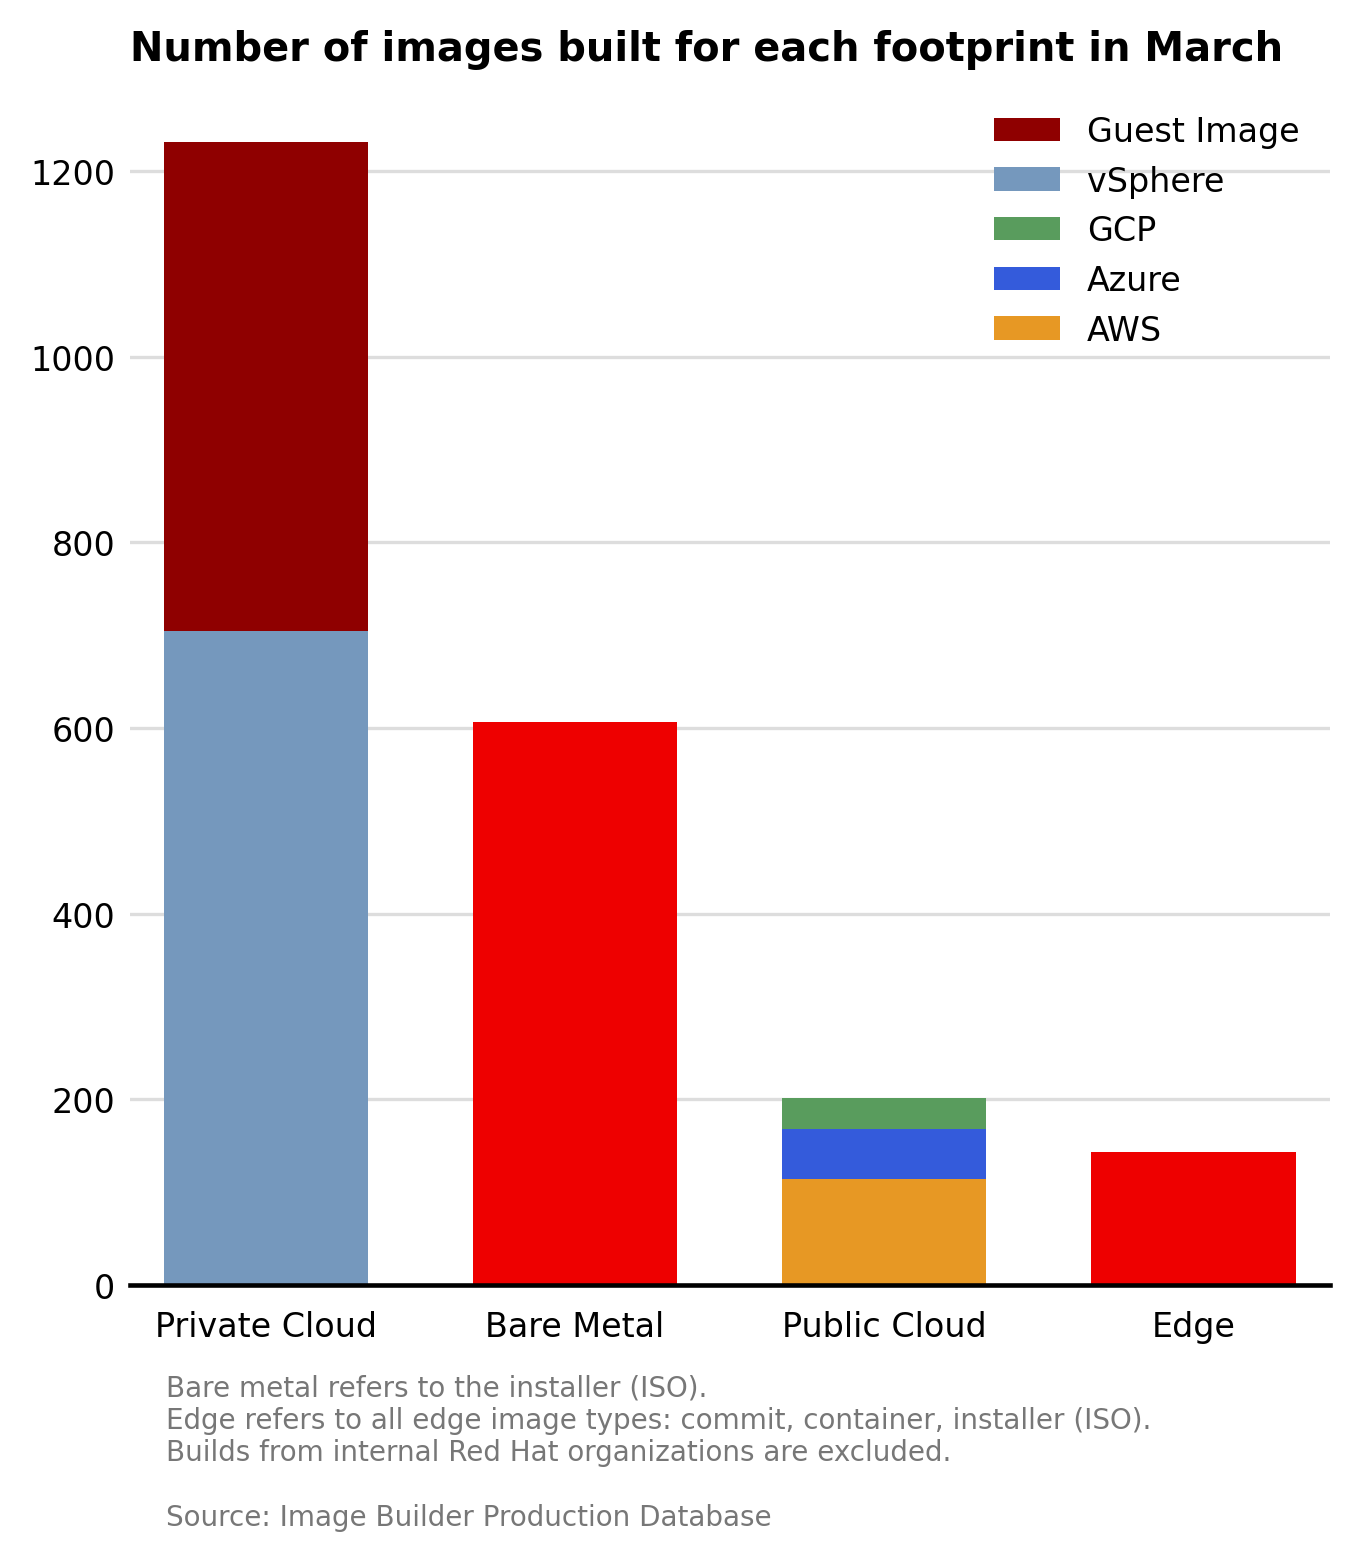

In [10]:
# Number of images for each footprint for the last month
fig = plt.figure(figsize=(4, 4))
prev_month_end = month_start - timedelta(days=1)
prev_month_start = datetime(year=prev_month_end.year, month=prev_month_end.month, day=1)

month_name = prev_month_end.strftime("%B")
month_builds = builds.loc[builds["created_at"] > prev_month_start]
ib.plot.footprints_stacked(month_builds, fig, title=f"Number of images built for each footprint in {month_name}")
print(f"{len(month_builds)} total builds in {month_name}")